this code classify Herlev dataset image into 2 classes(normal,abnormal)
i first used 3 CNNs and after that extracted features from 3 models and concatinat them to use as an input to diffrent classifiers ex: SVM, Bagging ...

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
%cd /content/drive/MyDrive/Projects/CervicalFuzzyDistanceEnsemble-main/

/content/drive/MyDrive/Projects/CervicalFuzzyDistanceEnsemble-main


In [2]:
!pip install numpy pandas matplotlib seaborn opencv-python tensorflow scikit-learn scikit-image scipy

In [4]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
import os
import pandas as pd
from sklearn.utils import shuffle

def generate_csv(path):
    print("CSV being generated")
    uniques = ["abnormal" , "normal"]
    dirs = ["Train" , "Test"]
    data = []
    for dir in dirs :
        for unique in uniques:
            directory = path + "/" + dir + "/" + unique

            for filename in os.listdir(directory):
                paths = directory + "/" + filename
                data.append([ filename , paths  , unique])

    df = pd.DataFrame(data, columns = ["filename" ,"path", "class"])
    df = shuffle(df)
    name = "csv_files/" + "Data-full-HERLEV-2-CLASS"
    df.to_csv(name, index = False)
    print("Generation Complete")
    return df

In [22]:
from sklearn.model_selection import KFold

def k_fold_splits(x , y , files_for_train_x , files_for_validation_x , files_for_train_y , files_for_validation_y , n_splits = 5    ):
  kf = KFold(n_splits = n_splits)
  for train_index, val_index in kf.split(x):

      x_train, x_val = x[train_index], x[val_index]
      y_train, y_val = y[train_index], y[val_index]

      files_for_train_x.append(x_train)
      files_for_validation_x.append(x_val)
      files_for_train_y.append(y_train)
      files_for_validation_y.append(y_val)

  print("K Fold Splits Complete")

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Model

def create_model(model_name,IMG_SIZE = 256, output = 5):

    IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
    if(model_name == "MobileNetV2" ):
        model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                            include_top=False,
                                                            weights='imagenet')
    elif(model_name == "InceptionV3"):
        model = tf.keras.applications.inception_v3.InceptionV3(input_shape=IMG_SHAPE,
                                                                        include_top=False,
                                                                        weights='imagenet')

    elif(model_name == "InceptionResNetV2"):
        model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=IMG_SHAPE,
                                                                                        include_top=False,
                                                                                        weights='imagenet')
    else:
        return

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(model.output)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dense(output, activation='softmax')(x)

    model = Model(inputs=model.input, outputs=x)
    my_model = tf.keras.models.clone_model(model)
    return my_model

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from matplotlib.pyplot import imread
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam
import cv2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


def encode_y(y):
  Y = []
  for i in y :
    if(i == "abnormal" ):
      Y.append(0)
    elif(i == "normal" ):
      Y.append(1)

  return  np.array(Y).astype("float32")

# convert file paths info nums
#then normalize
def process_x(x, target_size=(256, 256)):
    processed_images = []
    for i in x:
        try:
            image = imread(i)
            resized_image = cv2.resize(image, target_size)
            processed_images.append(resized_image)
        except Exception as e:
            print(f"Error processing image at path: {i}")
            print(f"Error message: {e}")

    return np.array(processed_images).astype("float32") / 255.0


In [25]:
def k_fold_separate(x_train , y_train , x_val ,y_val , model_name1,model_name2,model_name3 ,fold_no ,  NUM_EPOCHS = 70 , train_batch=16 , validation_batch = 16, lr=1e-3  ):

    train_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

    val_datagen = ImageDataGenerator()
    x_train , y_train , x_val ,y_val = process_x(x_train) , encode_y(y_train) , process_x(x_val) , encode_y(y_val)

    train =  train_datagen.flow(x_train, y_train, batch_size=train_batch)
    validation = val_datagen.flow(x_val ,y_val,
                          batch_size=validation_batch)
    test = x_val
    print('------------------------------------------------------------------------')
    print()
    print("fold no --- " , fold_no)
    print()
    print('------------------------------------------------------------------------')

    y_preds = []
    print()
    print(model_name1)
    print()

    model1 = create_model(model_name1)
    model1.compile(loss='sparse_categorical_crossentropy',
                  optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, decay=0.0001),
                  metrics=['accuracy'])
    print("Shape of x_train:", x_train.shape)
    print("Shape of y_train:", y_train.shape)

    history1 = model1.fit(x = train ,
                         validation_data= validation,
                         epochs=NUM_EPOCHS
                          )

    epochs_range = range(1, len(history1.history['accuracy']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, history1.history['loss'], label='Training loss')
    plt.plot(epochs_range, history1.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title(f'Loss vs. Epochs for fold {fold_no} Model 1: {model_name1}')
    plt.legend()
    plt.show()

    scores = model1.evaluate(validation)
    print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
    preds1 = model1.predict(test , batch_size = validation_batch )
    for pred in preds1 :
      y_preds.append(np.argmax(pred))
    print('Accuracy Score: ',accuracy_score(y_val,y_preds))
# ---------------------------------------------------------------
    y_preds = []
    print()
    print(model_name2)
    print()
    model2 = create_model(model_name2)

    model2.compile(loss='sparse_categorical_crossentropy',
                  optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, decay=0.0001),
                  metrics=['accuracy'])

    history2 = model2.fit(x = train ,
                         validation_data= validation,
                         epochs=NUM_EPOCHS
                        )

    epochs_range = range(1, len(history2.history['accuracy']) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, history2.history['loss'], label='Training loss')
    plt.plot(epochs_range, history2.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title(f'Loss vs. Epochs for fold {fold_no} Model 2: {model_name2}')
    plt.legend()
    plt.show()

    scores = model2.evaluate(validation)
    print(f'Score for fold {fold_no}: {model2.metrics_names[0]} of {scores[0]}; {model2.metrics_names[1]} of {scores[1]*100}%')
    preds2 = model2.predict(test , batch_size= validation_batch )
    for pred in preds2 :
      y_preds.append(np.argmax(pred))

    print('Accuracy Score: ',accuracy_score(y_val,y_preds))
# -----------------------------------------------------------------------------
    y_preds = []
    print()
    print(model_name3)
    print()

    model3 = create_model(model_name3)
    model3.compile(loss='sparse_categorical_crossentropy',
                  optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, decay=0.0001),
                  metrics=['accuracy'])

    history3 = model3.fit(x = train ,
                         validation_data= validation,
                         epochs=NUM_EPOCHS
                         )

    epochs_range = range(1, len(history3.history['accuracy']) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, history3.history['loss'], label='Training loss')
    plt.plot(epochs_range, history3.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title(f'Loss vs. Epochs for fold {fold_no} Model 3: {model_name3}')
    plt.legend()
    plt.show()

    scores = model3.evaluate(validation)
    print(f'Score for fold {fold_no}: {model3.metrics_names[0]} of {scores[0]}; {model3.metrics_names[1]} of {scores[1]*100}%')
    preds3 = model3.predict(test , batch_size=  validation_batch )
    for pred in preds3 :
      y_preds.append(np.argmax(pred))

    print('Accuracy Score: ',accuracy_score(y_val,y_preds))

    # print("Model_1 Summary")
    # print("***************************************************")
    # for i, layer in enumerate(model1.layers):
    #   print(i, layer.name)
    # print("***************************************************")
    # print("Model_2 Summary")
    # print("***************************************************")
    # for i, layer in enumerate(model2.layers):
    #   print(i, layer.name)
    # print("***************************************************")
    # print("Model_3 Summary")
    # print("***************************************************")
    # for i, layer in enumerate(model3.layers):
    #   print(i, layer.name)
    #------------------------------------------------------------
        # Feature Extraction

    intermediate_layer_model_1 = Model(inputs=model1.input, outputs=model1.layers[-1].output)
    intermediate_layer_model_2 = Model(inputs=model2.input, outputs=model2.layers[-1].output)
    intermediate_layer_model_3 = Model(inputs=model3.input, outputs=model3.layers[-1].output)

    featuresTrain_1 = intermediate_layer_model_1.predict(x_train)
    featuresTrain_1 = featuresTrain_1.reshape(featuresTrain_1.shape[0], -1)
    featuresTrain_2 = intermediate_layer_model_2.predict(x_train)
    featuresTrain_2 = featuresTrain_2.reshape(featuresTrain_2.shape[0], -1)
    featuresTrain_3 = intermediate_layer_model_3.predict(x_train)
    featuresTrain_3 = featuresTrain_3.reshape(featuresTrain_3.shape[0], -1)

    featuresVal_1 = intermediate_layer_model_1.predict(x_val)
    featuresVal_1 = featuresVal_1.reshape(featuresVal_1.shape[0], -1)
    featuresVal_2 = intermediate_layer_model_2.predict(x_val)
    featuresVal_2 = featuresVal_2.reshape(featuresVal_2.shape[0], -1)
    featuresVal_3 = intermediate_layer_model_3.predict(x_val)
    featuresVal_3 = featuresVal_3.reshape(featuresVal_3.shape[0], -1)

    featuresTrain = np.concatenate((featuresTrain_1, featuresTrain_2, featuresTrain_3), axis=1)
    featuresVal = np.concatenate((featuresVal_1, featuresVal_2, featuresVal_3), axis=1)


    # SVM Classification
    svm_classifier = SVC(kernel='linear', C=1)
    svm_classifier.fit(featuresTrain, y_train)
    svm_predictions = svm_classifier.predict(featuresVal)
    svm_accuracy = accuracy_score(y_val,svm_predictions)
    print(f'SVM Accuracy: {svm_accuracy}')

    # Random Forest Classification
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(featuresTrain, y_train)
    rf_predictions = rf_classifier.predict(featuresVal)
    rf_accuracy = accuracy_score(y_val, rf_predictions)
    print(f'Random Forest Accuracy: {rf_accuracy}')

    # Bagging Classifier
    bagging_classifier = BaggingClassifier(base_estimator=rf_classifier, n_estimators=10, random_state=42)
    bagging_classifier.fit(featuresTrain, y_train)
    bagging_predictions = bagging_classifier.predict(featuresVal)
    bagging_accuracy = accuracy_score(y_val, bagging_predictions)

    # Gradient Boosting Classifier
    gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_classifier.fit(featuresTrain, y_train)
    gb_predictions = gb_classifier.predict(featuresVal)
    gb_accuracy = accuracy_score(y_val, gb_predictions)
    print(f'Gradient Boosting Classifier Accuracy: {gb_accuracy}')

    # Logistic Regression
    lr_classifier = LogisticRegression(max_iter=1000)
    lr_classifier.fit(featuresTrain, y_train)
    lr_predictions = lr_classifier.predict(featuresVal)
    lr_accuracy = accuracy_score(y_val, lr_predictions)

In [26]:
parser = argparse.ArgumentParser()
parser.add_argument('--num_epochs', type=int, default = 70)
parser.add_argument('--path', type=str, default = '/content/drive/MyDrive/Dataset/Herlev_2_Class')
parser.add_argument('--batch_size', type=int, default = 16)
parser.add_argument('--kfold', type=int, default = 5)
parser.add_argument('--lr', type=float, default = 1e-4)
args = parser.parse_args(args=[])
df = generate_csv(args.path)

CSV being generated
Generation Complete


In [27]:
y = np.array(list(df["class"]))
x = np.array(list( df["path"]))

files_for_train_x = []
files_for_validation_x = []
files_for_train_y = []
files_for_validation_y = []

k_fold_splits(x,y, files_for_train_x ,  files_for_validation_x ,
              files_for_train_y , files_for_validation_y,  n_splits = args.kfold )

K Fold Splits Complete


------------------------------------------------------------------------

fold no ---  1

------------------------------------------------------------------------

InceptionResNetV2

219055592/219055592 [==============================] - 1s 0us/step
Shape of x_train: (733, 256, 256, 3)
Shape of y_train: (733,)
Epoch 1/70
46/46 [==============================] - 61s 690ms/step - loss: 0.6311 - accuracy: 0.7490 - val_loss: 0.6634 - val_accuracy: 0.7228
Epoch 2/70
46/46 [==============================] - 20s 439ms/step - loss: 0.4298 - accuracy: 0.8172 - val_loss: 0.6266 - val_accuracy: 0.7228
Epoch 3/70
46/46 [==============================] - 19s 420ms/step - loss: 0.3587 - accuracy: 0.8527 - val_loss: 0.9249 - val_accuracy: 0.7228
Epoch 4/70
46/46 [==============================] - 20s 423ms/step - loss: 0.4157 - accuracy: 0.8186 - val_loss: 1.0550 - val_accuracy: 0.7228
Epoch 5/70
46/46 [==============================] - 20s 421ms/step - loss: 0.3770 - accuracy: 0.8513 - val_loss: 0.9

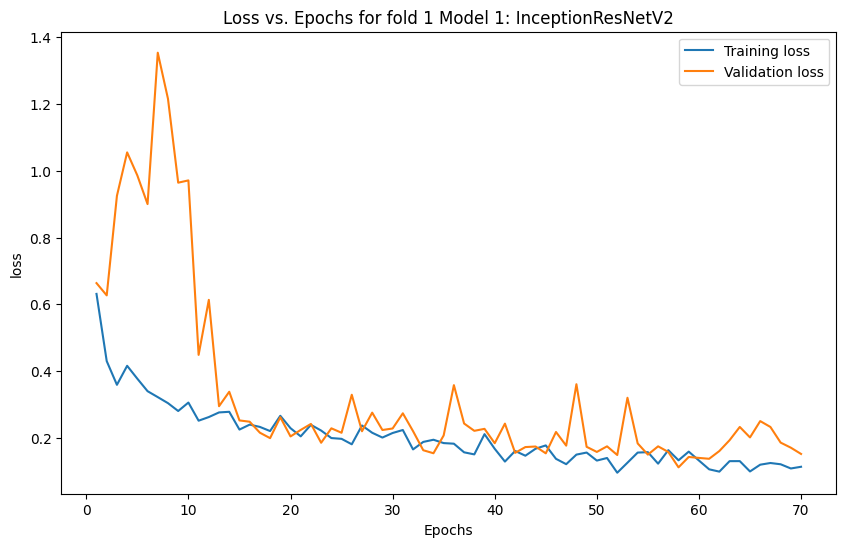

12/12 [==============================] - 1s 118ms/step - loss: 0.1516 - accuracy: 0.9511
Score for fold 1: loss of 0.15163670480251312; accuracy of 95.1086938381195%
12/12 [==============================] - 5s 117ms/step
Accuracy Score:  0.9510869565217391

InceptionV3

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/70
46/46 [==============================] - 32s 449ms/step - loss: 0.7570 - accuracy: 0.7558 - val_loss: 0.7524 - val_accuracy: 0.7228
Epoch 2/70
46/46 [==============================] - 14s 311ms/step - loss: 0.5004 - accuracy: 0.7995 - val_loss: 0.7092 - val_accuracy: 0.7228
Epoch 3/70
46/46 [==============================] - 14s 311ms/step - loss: 0.4947 - accuracy: 0.7967 - val_loss: 0.8791 - val_accuracy: 0.7228
Epoch 4/70
46/46 [==============================] - 14s 308ms/step - loss: 0.5142 - accuracy: 0.8090 - val_loss: 0.8880 - val_accuracy: 0.7228
Epoch 5/70
46/46 [==============================] - 14s 312ms/step - loss: 0.4803 - accuracy

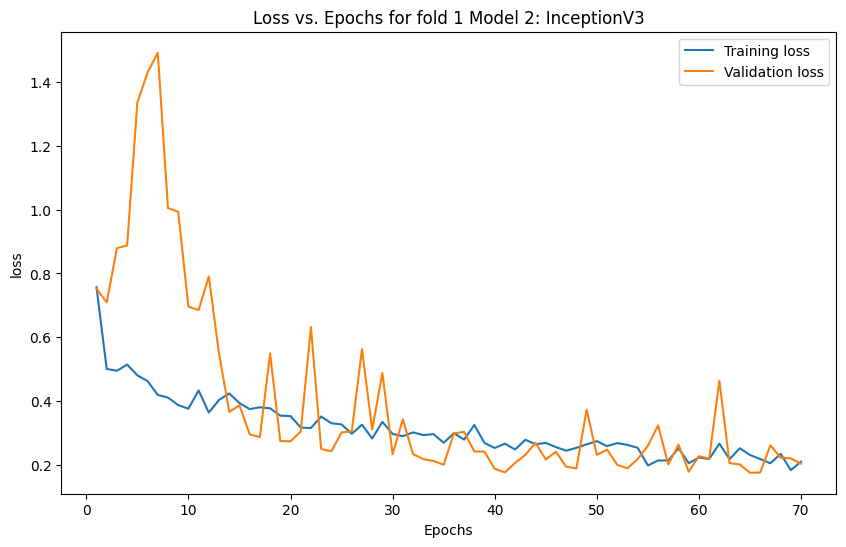

12/12 [==============================] - 1s 54ms/step - loss: 0.2031 - accuracy: 0.9185
Score for fold 1: loss of 0.20311345160007477; accuracy of 91.847825050354%
12/12 [==============================] - 2s 52ms/step


Accuracy Score:  0.9184782608695652

MobileNetV2

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/70
46/46 [==============================] - 23s 331ms/step - loss: 0.6631 - accuracy: 0.7462 - val_loss: 1.5709 - val_accuracy: 0.7228
Epoch 2/70
46/46 [==============================] - 13s 272ms/step - loss: 0.5572 - accuracy: 0.7844 - val_loss: 1.5320 - val_accuracy: 0.7228
Epoch 3/70
46/46 [==============================] - 13s 275ms/step - loss: 0.5072 - accuracy: 0.7954 - val_loss: 1.4881 - val_accuracy: 0.7228
Epoch 4/70
46/46 [==============================] - 13s 272ms/step - loss: 0.5068 - accuracy: 0.7885 - val_loss: 1.4461 - val_accuracy: 0.7228
Epoch 5/70
46/46 [==============================] - 14s 304ms/step - loss: 0.5129 - accuracy: 0.7858 - val_loss: 1.3990 - val_accuracy: 0.7228
Epoch 6/70
46/46 [==============================] - 13s 272ms/step - loss: 0.5003 - accuracy: 0.7967 - val_loss: 1.3803 - val_accuracy: 0.7228
Epoch 7/70
46/46 [===========

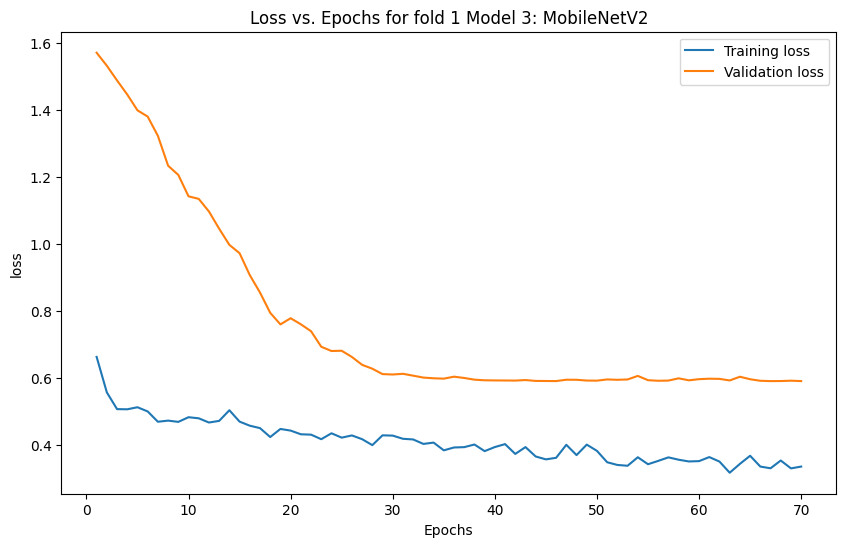

12/12 [==============================] - 0s 31ms/step - loss: 0.5909 - accuracy: 0.7228
Score for fold 1: loss of 0.5909093022346497; accuracy of 72.28260636329651%
12/12 [==============================] - 1s 26ms/step
Accuracy Score:  0.7228260869565217
6/6 [==============================] - 1s 242ms/step
SVM Accuracy: 0.9619565217391305
Random Forest Accuracy: 0.9565217391304348


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Gradient Boosting Classifier Accuracy: 0.9565217391304348
------------------------------------------------------------------------

fold no ---  2

------------------------------------------------------------------------

InceptionResNetV2

Shape of x_train: (733, 256, 256, 3)
Shape of y_train: (733,)
Epoch 1/70
46/46 [==============================] - 43s 507ms/step - loss: 0.6106 - accuracy: 0.7558 - val_loss: 0.6540 - val_accuracy: 0.7283
Epoch 2/70
46/46 [==============================] - 20s 440ms/step - loss: 0.4018 - accuracy: 0.8404 - val_loss: 0.8814 - val_accuracy: 0.7283
Epoch 3/70
46/46 [==============================] - 20s 439ms/step - loss: 0.3660 - accuracy: 0.8486 - val_loss: 0.8651 - val_accuracy: 0.7283
Epoch 4/70
46/46 [==============================] - 20s 427ms/step - loss: 0.3862 - accuracy: 0.8527 - val_loss: 1.0394 - val_accuracy: 0.7283
Epoch 5/70
46/46 [==============================] - 21s 445ms/step - loss: 0.3379 - accuracy: 0.8568 - val_loss: 1.4138 - val

KeyboardInterrupt: 

In [28]:
N = len(files_for_train_x)
for i in range(0,N):
    k_fold_separate(files_for_train_x[i] , files_for_train_y[i] ,
           files_for_validation_x[i] ,files_for_validation_y[i] ,
           "InceptionResNetV2" , "InceptionV3" ,"MobileNetV2" ,i+1 ,
             NUM_EPOCHS = args.num_epochs , train_batch=args.batch_size ,
              validation_batch = args.batch_size, lr=args.lr)